# TAOS drifter deployments: schedule route for drifter deployments


In [2]:
import os
from glob import glob

from datetime import datetime
from time import sleep

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import pyproj

import taos.utils as ut
import taos.insitu as ins
from taos.insitu import rad2deg, knot, lonc, latc

---

## useful metrics

In [3]:
ins.metrics_cheatsheet(lonc, latc)

 lon: 1 deg = 72.44km,  0.1 deg = 7.2km,  0.01 deg = 724.4m,  0.001 deg = 72.4m
 lon: 1 deg = 72.44km,  1 min = 1207.3m,  .1 min = 120.7m,  0.01 min = 12.1m
 lon: 1 deg = 72.44km,  1 sec = 20.1m,  .1 sec = 2.0m
-----------------------------------------------------------------
 lat: 1 deg = 111.23km,  0.1 deg = 11.1km,  0.01 deg = 1112.2m,  0.001 deg = 111.2m
 lat: 1 deg = 111.23km,  1 min = 1853.7m,  .1 min = 185.4m,  0.01 min = 18.5m
 lat: 1 deg = 111.23km,  1 sec = 30.9m,  .1 sec = 3.1m


🐷🐷🐷🐷🐨🌼🌼🌼💐💐🌾🌖🌾😋😋👩‍🦳👩‍🦳§😄😁😁😁😀😄😄(😃😄(😚😚😗)🙃😇😇😇😇🥳🥳😏🥳🥳😏🥳😏🥳)😡😡😡😡😡😡👹👹👹👺👺👺👾👽👾😿😿😿😸😹👍🖐🏻👉🏽👀👥👥👥👥👥👥👥🧑🏽‍🦰🧑🏽‍🦰👱‍♂️👱‍♂️👱‍♂️👱‍♂️😡🤕à🤕🤕🤒😷

---

## deployment route resolution 

In [4]:
# deployment geometry
R, theta, N = 1e3, 0/rad2deg, 5
anchor = ins.stations.loc["LSTOuistreham"]
lon_a, lat_a = anchor["lon"], anchor["lat"]
center_loc = 2

# other variables
speed = 10 # knots
time_waiting = 5*60 # seconds

lon, lat, X = ins.build_square_geo(lon_a, lat_a, R, theta, rotation=-1, center_loc=center_loc)

In [5]:
dash = ins.dashboard_route(lon, lat, 
                       ship_speed=speed, square_radius=R/1e3, square_theta=theta, 
                       square_center=center_loc, time_waiting=time_waiting/60,
                      )
dash.grid

Output()

/Users/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


GridspecLayout(children=(Button(description='Update', icon='check', layout=Layout(grid_area='widget001'), styl…

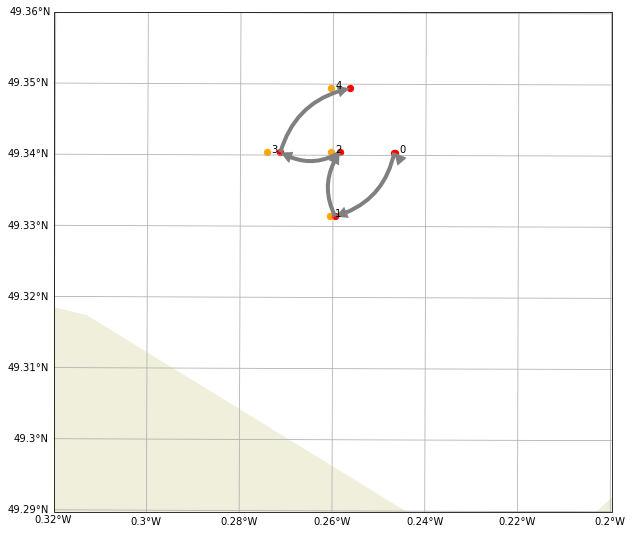

In [8]:
ins.plot_deployments_route(dash.lon_vertices, dash.lat_vertices, dash.df, 
                           bathy=False, land=dict(scale="10m"), coast_resolution=None,
                          )